In [165]:
### Hide the input codes   ###
from IPython.display import HTML
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


# UnifiedDataLayers
*Author: @krissykodes *

### Summary: 
One of the applications of hexagons is to be able to combine different datasets with different geographic shapes and forms. In this notebook we are going through an example of how to bring the US census data, TIV, and AAL to the hexagon aperture and then how to visualize the data to gain insight.

### Data
* **POLYGON:** Census Tract Data [[Source]](https://www.census.gov/data.html)
* **POINT:** Sum of TIV from Item 12
* **HEX:** Contrived AAL from AIR Model

### Import & Functions

In [166]:
# import
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import shapely
import rtree
import geopandas
import xarray as xr
from geopandas import GeoDataFrame
from shapely.geometry import mapping
from shapely.ops import cascaded_union#, unary_union
import h3
import base64
import urllib
import tempfile
# import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import rasterio
%matplotlib inline

#Functions
def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(12,12), colormap='hot'):    
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize);
    plt.xticks([], []); plt.yticks([], [])

def aperture_downsampling(df, hex_col, metric_col, coarse_aperture_size):
    df_coarse = df.copy()
    coarse_hex_col = 'hex{}'.format(coarse_aperture_size)
    df_coarse[coarse_hex_col] = df_coarse[hex_col].apply(lambda x: h3.h3_to_parent(x,coarse_aperture_size))
    dfc = df_coarse.groupby([coarse_hex_col])[[metric_col,]].mean().reset_index()
    dfc['lat'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfc['lng'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfc

def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]] 
    dfk.index = dfk[hex_col]
    dfs =  (dfk[hex_col]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,k)))).stack()
                 .to_frame('hexk').reset_index(1, drop=True).reset_index()
                 .merge(df[[hex_col,metric_col]]).fillna(0)
                 .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
                 .reset_index()
                 .rename(index=str, columns={"hexk": hex_col}))
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfs

def weighted_kring_smoothing(df, hex_col, metric_col, coef):
    # normalize the coef
    a = []
    for k, coe in enumerate(coef):
        if k == 0:
            a.append(coe)
        else:
            a.append(k * 6 * coe)
    coef = [c / sum(a) for c in coef]
    
    # weighted smoothing 
    df_agg = df[[hex_col]]
    df_agg['hexk'] = df_agg[hex_col]
    df_agg.set_index(hex_col,inplace=True)
    temp2 = [df_agg['hexk'].reset_index()]
    temp2[-1]['k'] = 0
    K=len(coef)-1 
    for k in range(1,K+1):
        temp2.append((df_agg['hexk']
                     .apply(lambda x: pd.Series(list(h3.hex_ring(x,k)))).stack()
                     .to_frame('hexk').reset_index(1, drop=True).reset_index()
                ))
        temp2[-1]['k'] = k
    df_all = pd.concat(temp2).merge(df)
    df_all[metric_col] = df_all[metric_col]*df_all.k.apply(lambda x:coef[x])
    dfs = df_all.groupby('hexk')[[metric_col]].sum().reset_index().rename(index=str, columns={"hexk": hex_col})
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs

# Data 

## Point to Hex

### Load Total Insured Value

In [167]:
df311kr = pd.read_csv("data/item12.csv")
#remove outliers
df311k =df311kr[df311kr['State']!= 'HI']
df311k =df311k[df311k['lat'].between(1,55)]
df311k =df311k[df311k['State']!= 'AK']
df311k=(df311k[['TIV','lat','lng','county','Premium','State']])
df311k.head()
# #plot points
# df311k.plot(x='lng',y='lat',style='.',alpha=1,figsize=(12,12));
# plt.title('TIV count');

,TIV,lat,lng,county,Premium,State
0,10000.0,38.76,-82.95,Scioto,44.0,OH
1,80581.0,39.80,-84.25,Montgomery,586.0,OH
2,70300.0,39.93,-83.83,Clark,443.0,OH
3,715000.0,38.52,-75.05,Sussex,3840.0,DE
4,37500.0,33.64,-112.13,Maricopa,163.0,AZ


In [168]:
df311kr.dtypes

Policy       object
State        object
Premium     float64
TIV         float64
hu_aal      float64
eq_aal      float64
sl_aal      float64
ff_aal      float64
st_aal      float64
ws_aal      float64
wf_aal      float64
if_aal      float64
tr_aal      float64
lat         float64
lng         float64
county       object
zip_code    float64
dtype: object

In [169]:
#Asign Hex size
APERTURE_SIZE = 7
hex_col = 'hex'+str(APERTURE_SIZE)

# find hexs containing the points
df311k[hex_col] = df311k.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE_SIZE),1)
df311k.head()

,TIV,lat,lng,county,Premium,State,hex7
0,10000.0,38.76,-82.95,Scioto,44.0,OH,872a9e966ffffff
1,80581.0,39.80,-84.25,Montgomery,586.0,OH,872a90608ffffff
2,70300.0,39.93,-83.83,Clark,443.0,OH,872a903a1ffffff
3,715000.0,38.52,-75.05,Sussex,3840.0,DE,872aad2eeffffff
4,37500.0,33.64,-112.13,Maricopa,163.0,AZ,8729b6c23ffffff


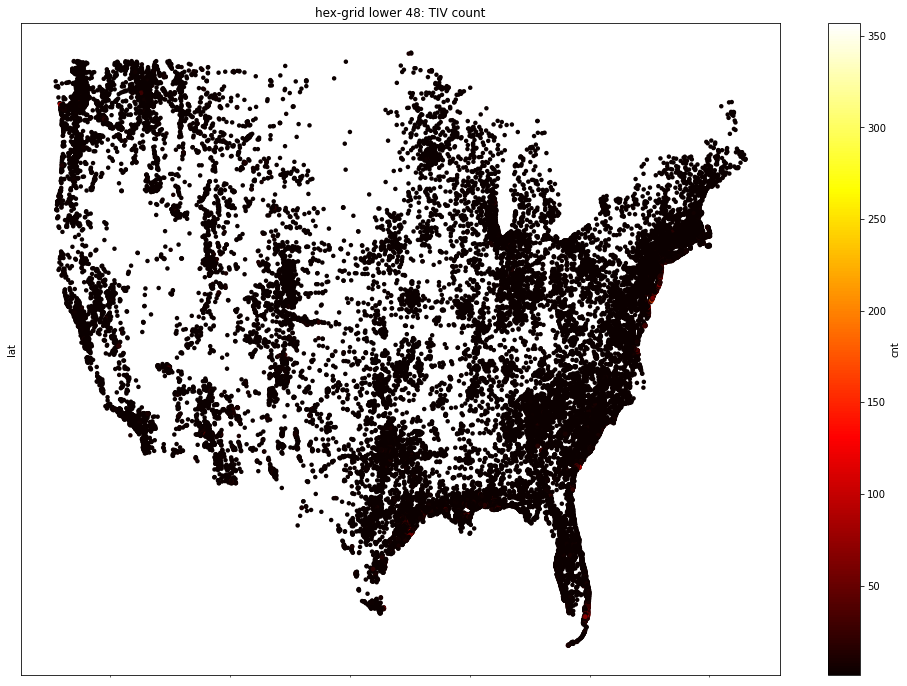

In [170]:
# aggregate the points
df311gkr = df311k.groupby(hex_col).size().to_frame('cnt').reset_index()
df311gkr.head()
#find center of hex for visualization
df311gkr['lat'] = df311gkr[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df311gkr['lng'] = df311gkr[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# plot the hexs
plot_scatter(df311gkr, metric_col='cnt', marker='o',figsize=(17,12))
plt.title('hex-grid lower 48: TIV count');

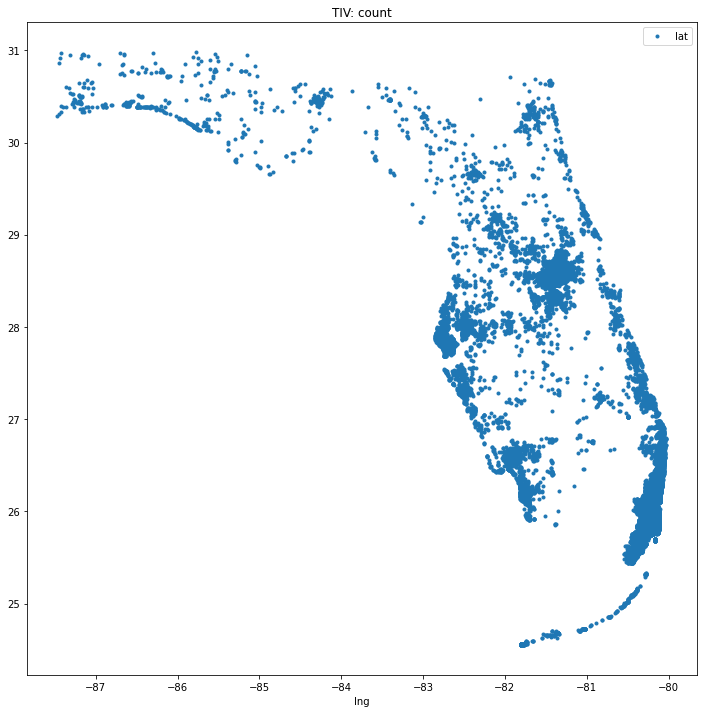

In [171]:
df311fl =df311k[df311k['State']== 'FL']
df311fl.plot(x='lng',y='lat',style='.',alpha=1,figsize=(12,12));
plt.title('TIV: count');

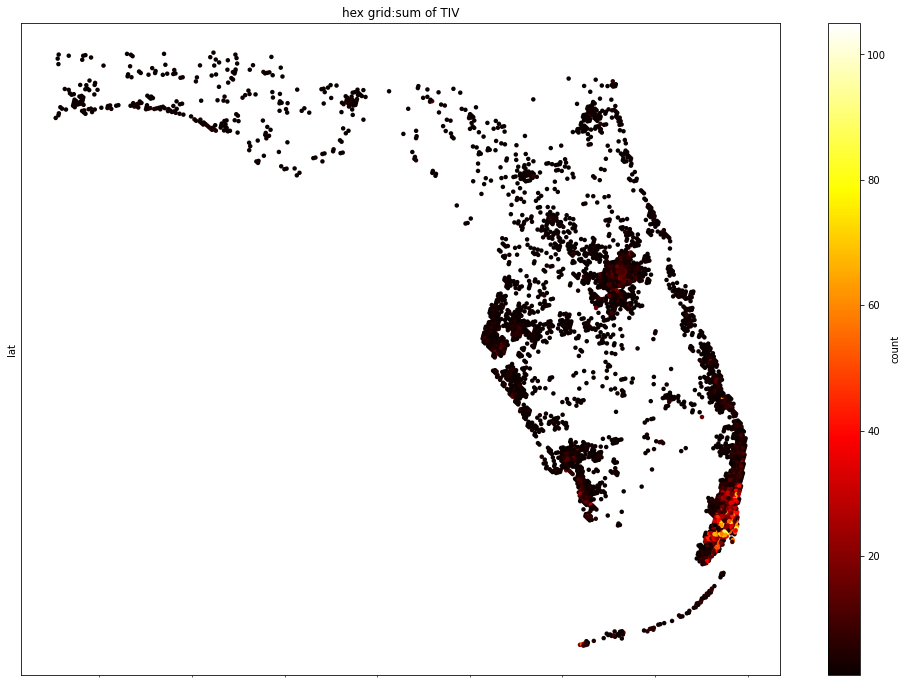

In [172]:
df311gkrs = df311fl.groupby(hex_col).TIV.agg(list).to_frame('ids').reset_index()
df311gkrs.head()

df311gkrs['sum']=(df311gkrs['ids'].apply(lambda totals:sum(totals)))
df311gkrs.head()
df311gkrs['count']=(df311gkrs['ids'].apply(lambda totals:len(totals)))
df311gkrs['per']=df311gkrs['sum']/df311gkrs['count']
df311gkrs.head()

#find center of hex for visualization
df311gkrs['lat'] = df311gkrs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df311gkrs['lng'] = df311gkrs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# plot the hexs
plot_scatter(df311gkrs, metric_col='count', marker='o',figsize=(17,12))
plt.title('hex grid:sum of TIV');

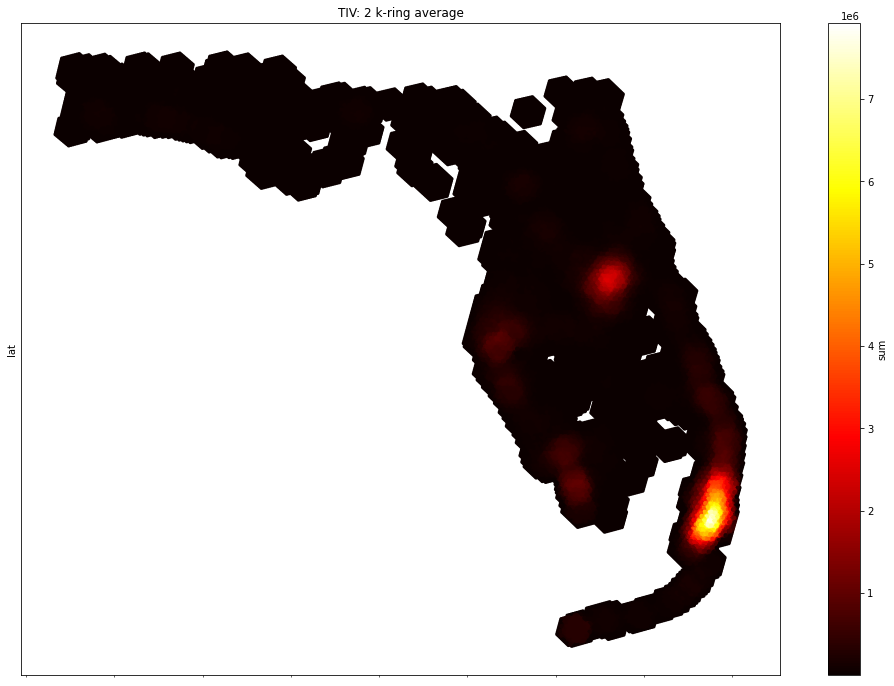

In [173]:
#kring_smoothing
k = 8
df311sk= kring_smoothing(df311gkrs, hex_col, metric_col='sum', k=k)
# print('sum sanity check:', df311s['cnt'].sum() / df311g['cnt'].sum())
plot_scatter(df311sk, metric_col='sum', marker='o',figsize=(17,12))
plt.title('TIV: 2 k-ring average');

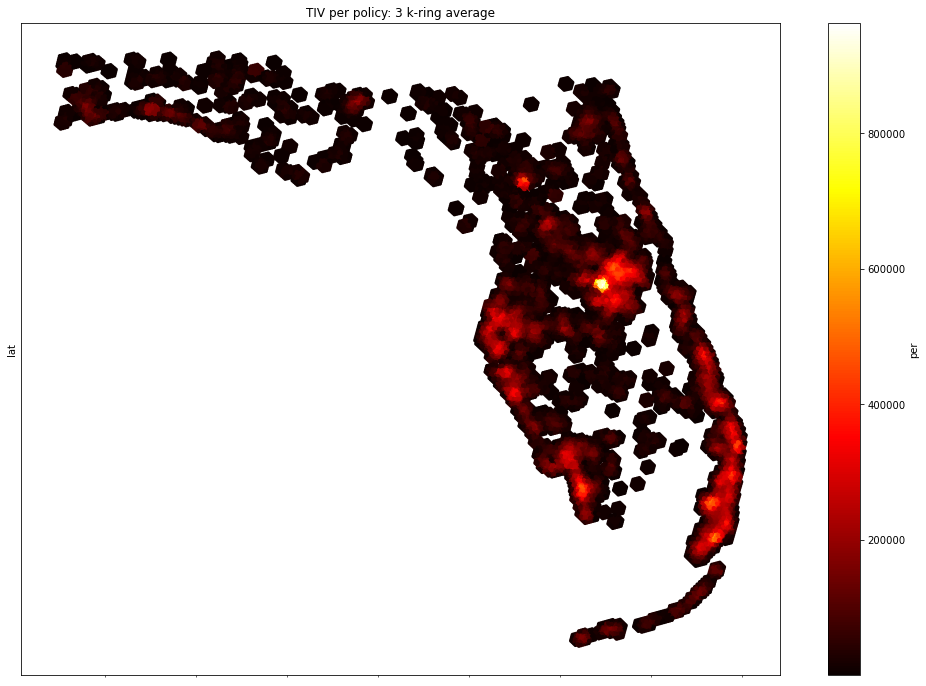

In [174]:
#kring_smoothing
k = 3
df311sk= kring_smoothing(df311gkrs, hex_col, metric_col='per', k=k)
# print('sum sanity check:', df311s['cnt'].sum() / df311g['cnt'].sum())
plot_scatter(df311sk, metric_col='per', marker='o',figsize=(17,12))
plt.title('TIV per policy: 3 k-ring average');

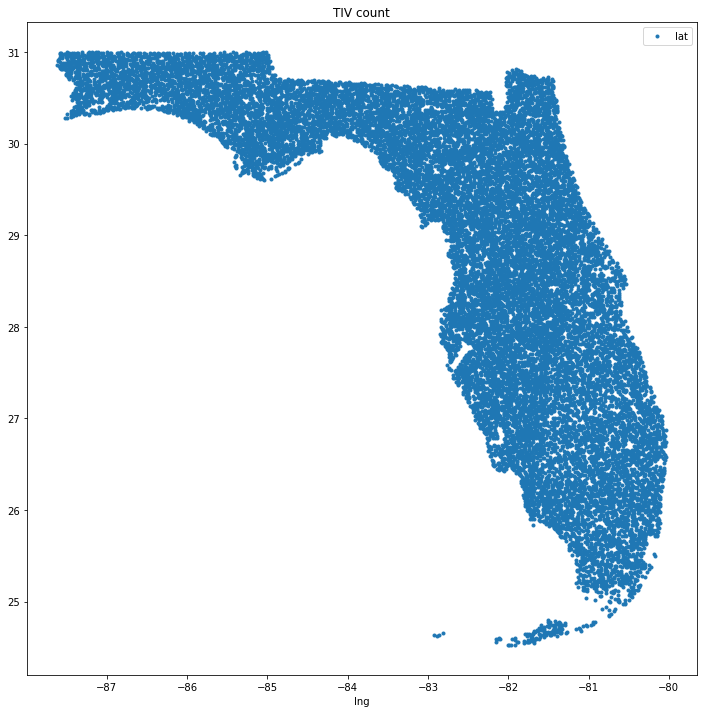

In [175]:
gdf=pd.read_csv("data/flcontrived.csv")
gdf.head()

#plot points
gdf.plot(x='lng',y='lat',style='.',alpha=1,figsize=(12,12));
plt.title('TIV count');


In [176]:
#Asign Hex size
APERTURE = 6
hex_column = 'hex'+str(APERTURE)

# find hexs containing the points
gdf[hex_column] = gdf.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE),1)

gdf.head()



,grid_nb,state_contrivedGridLevel,point_count_contrivedGridLevel,hu_wsst_contrivedGridLevel,hu_stnd_contrivedGridLevel,eq_shake_contrivedGridLevel,ff_contrivedGridLevel,sl_contrivedGridLevel,st_contrivedGridLevel,ws_contrivedGridLevel,...,coastalarea_tp_gridprimary,fipsstate_cd_gridprimary,fipscounty_cd_gridprimary,gridcenterpoint_gs_gridprimary,gridshape_gs_gridprimary,gridcreate_dt_gridprimary,watercoverage_pc_gridprimary,lng,lat,hex6
0,CJS-1578,FL,43,840.5,776.9,3.3,0.0,0.1,182.1,37.6,...,3,12,33,POINT (-87.601518 30.843455),"POLYGON ((-87.590675 30.842696,-87.595264 30.8...",4/5/18,0,-87.601518,30.843455,8644504dfffffff
1,CJT-1575,FL,43,825.9,763.5,3.2,0.0,0.1,158.6,40.7,...,3,12,33,POINT (-87.57939 30.894421),"POLYGON ((-87.56854 30.893661,-87.573129 30.90...",4/5/18,0,-87.579390,30.894421,864452b77ffffff
2,CJU-1570,FL,43,828.6,765.3,3.6,0.0,0.1,239.9,41.9,...,3,12,33,POINT (-87.555551 30.960261),"POLYGON ((-87.544692 30.959499,-87.549283 30.9...",4/5/18,0,-87.555551,30.960261,864452b57ffffff
3,CJU-1572,FL,43,864.0,798.5,3.1,0.0,0.1,221.8,39.5,...,3,12,33,POINT (-87.558911 30.93049),"POLYGON ((-87.548056 30.929728,-87.552646 30.9...",4/5/18,0,-87.558911,30.930490,864452b77ffffff
4,CJU-1579,FL,43,888.8,820.5,3.4,0.0,0.2,217.5,36.3,...,3,12,33,POINT (-87.57065 30.826268),"POLYGON ((-87.55981 30.825507,-87.564395 30.83...",4/5/18,0,-87.570650,30.826268,8644504d7ffffff


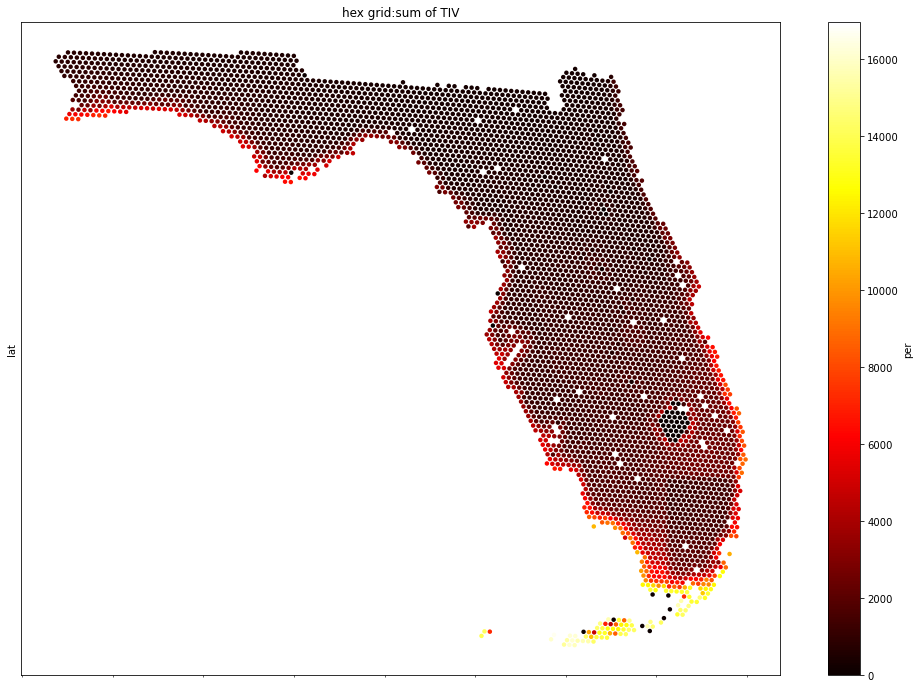

In [177]:
gdfg = gdf.groupby(hex_column).hu_wsst_contrivedGridLevel.agg(list).to_frame('ids').reset_index()

gdfg['sum']=(gdfg['ids'].apply(lambda totals:sum(totals)))
gdfg['count']=(gdfg['ids'].apply(lambda totals:len(totals)))
gdfg['per']=gdfg['sum']/gdfg['count']
gdfg.head()

#find center of hex for visualization
gdfg['lat'] = gdfg[hex_column].apply(lambda x: h3.h3_to_geo(x)[0])
gdfg['lng'] = gdfg[hex_column].apply(lambda x: h3.h3_to_geo(x)[1])

# plot the hexs
plot_scatter(gdfg, metric_col='per', marker='o',figsize=(17,12))
plt.title('hex grid:sum of TIV');

In [178]:
#kring_smoothing
k = 3
gdfgk= kring_smoothing(gdfg, hex_col, metric_col='per', k=k)
# print('sum sanity check:', df311s['cnt'].sum() / df311g['cnt'].sum())
plot_scatter(gdfgk, metric_col='per', marker='o',figsize=(17,12))
plt.title('TIV per policy: 3 k-ring average');

KeyError: "None of [Index(['hex7'], dtype='object')] are in the [columns]"

## Polygon to Hex

### Load Census Tract Data

In [ ]:
METRIC_COL = 'SE_T002_002' #population density

# Load Census Tract (CT) ShapeFile
gdf=GeoDataFrame.from_file(ct_shape_link)
gdf['gdf'] = gdf['BoroCT2010'].astype(str) 

# Load CT Data & Join w/ ShapeFile
df = pd.read_csv(ct_data_link, usecols=['BoroCT2010',METRIC_COL])
df['BoroCT2010'] = df['BoroCT2010'].astype(str)

# join metadata
gdf = df.merge(gdf).fillna(0)
gdf.crs = {"init": "epsg:4326"}
gdf.sample(3)
gdf = GeoDataFrame(gdf)

# Visualize Population Density per Census Tract
f, ax = plt.subplots(figsize=(12,12)); 
ax.get_xaxis().set_visible(False); 
ax.get_yaxis().set_visible(False)
gdf.plot(column=METRIC_COL,colormap='viridis',alpha=1,linewidth=0.05,ax=ax)
plt.title('census tract: population density');

### Census Polygon to Hex 

In [ ]:
APERTURE_SIZE = 10 
# Unify the CT boundries
union_poly = cascaded_union(gdf.geometry)

# Find the hexs within the city boundary using PolyFill
hex_list=[]
for n,g in enumerate(union_poly):
    print(n,'\r')
    temp  = mapping(g)
    temp['coordinates']=[[[j[1],j[0]] for j in i] for i in temp['coordinates']]  
    hex_list.extend(h3.polyfill(temp,APERTURE_SIZE))

# create hex dataframe
hex_col = 'hex{}'.format(APERTURE_SIZE)
dfh = pd.DataFrame(hex_list,columns=[hex_col])
print('Sanity Check\nnumber of hexes:', len(hex_list))
print('number of duplicates:', len(hex_list) - len(dfh.drop_duplicates()))

# add lat & lng of center of hex 
dfh['lat']=dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
dfh['lng']=dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# create Point object based on hex latlng
dfh['geometry'] = dfh.apply(lambda x: shapely.geometry.Point(x.lng,x.lat),1)
dfh.crs = {"init": "epsg:4326"}

# plot hex latlng
dfh.plot(x='lng',y='lat',style='.',alpha=.1,figsize=(12,12));
plt.title('hex-grid: nyc')
dfh = GeoDataFrame(dfh)
# Intersect Hex Point with CT Polygon
df_ct = geopandas.tools.sjoin(gdf, dfh, how="inner")
df_ct.sample(3)

In [ ]:
# Visualize Hexagons
plot_scatter(pd.DataFrame(df_ct), metric_col=METRIC_COL, marker='.')
plt.title('hex-grid: population density');

### Spatial Weighted Smoothing

In [ ]:
# kring smoothing coefficients
coef = [1, .8, .4, .15, 0.05]
plt.plot(coef)
plt.xlabel('K-ring')
plt.ylabel('Smoothing Coef')

# weighted kring smoothing
df_ct_kw = weighted_kring_smoothing(df_ct, hex_col, metric_col=METRIC_COL, coef=coef)
print('sum sanity check:', df_ct_kw[METRIC_COL].sum() / df_ct[METRIC_COL].sum())
plot_scatter(df_ct_kw, metric_col=METRIC_COL, marker='.')
plt.title('hex-grid: smoothed population density');

### Spatial Hierarchical 

In [ ]:
# Spatial Hierarchy using h3_to_parent
coarse_aperture_size = 9
df_coarse = aperture_downsampling(df_ct_kw, hex_col, metric_col=METRIC_COL, coarse_aperture_size=coarse_aperture_size)
print('number of hex:', len(df_ct_kw))
print('number of coarse hex:', len(df_coarse))
plot_scatter(df_coarse, metric_col=METRIC_COL, marker='o')
plt.title('hex-grid: population density');

In [ ]:
# Aperture 8
_ = aperture_downsampling(df_ct, hex_col, metric_col=METRIC_COL, coarse_aperture_size=8)
plot_scatter(pd.DataFrame(_) , metric_col=METRIC_COL, marker='o',figsize=(8,6))
plt.title('hex-grid: population density');

## Raster to Hex

### Load Digital Elevation Model Data

In [ ]:
# create temp directory for GeoTiff file processing
temp_dir = tempfile.mkdtemp()

# download & decode GeoTiff data
open(temp_dir+'nyc_dem.tif', 'wb').write(base64.b64decode(urllib.request.urlopen(nyc_dem_link).read()))

In [ ]:
# Translate tif to XYZ dataframe
df = (xr.open_rasterio(temp_dir+'nyc_dem.tif')
      .sel(band=1)
      .to_pandas()
      .stack()
      .reset_index()
      .rename(columns={'x': 'lng', 'y': 'lat', 0: 'elevation'}))

In [ ]:
# ignore the missing values
df = df[df.elevation>-1000]

# Visualize the elevation
plot_scatter(df, metric_col='elevation', marker='.', colormap='gray')

### DEM Raster to Hex

In [ ]:
APERTURE_SIZE = 9
hex_col = 'hex'+str(APERTURE_SIZE)

# find hexs containing the points
df[hex_col] = df.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE_SIZE),1)

# calculate elevation average per hex
df_dem = df.groupby(hex_col)['elevation'].mean().to_frame('elevation').reset_index()

#find center of hex for visualization
df_dem['lat'] = df_dem[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df_dem['lng'] = df_dem[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# plot the hexes
plot_scatter(df_dem, metric_col='elevation', marker='o')
plt.title('hex-grid: elevation');

# Unifying Data Layers

In [ ]:
dfu = df_coarse[[METRIC_COL,hex_col]].merge(df311s[[hex_col,'cnt']]).merge(df_dem[[hex_col,'elevation']])
dfu.set_index(hex_col,inplace=True)
dfu.rename(index=str, columns={METRIC_COL: "population","cnt":"noise_complaints"},inplace=True)
dfu.population = dfu.population.clip(upper=dfu.population.quantile(.9))
dfu.noise_complaints = dfu.noise_complaints.clip(upper=dfu.noise_complaints.quantile(.9))
dfu.elevation = dfu.elevation.clip(upper=dfu.elevation.quantile(.9))
pd.plotting.scatter_matrix(dfu, alpha=0.05,figsize=(15,15));
# dfu['lat']=dfu['hex10'].apply(lambda x: h3.h3_to_geo(x)[0])
# dfu['lng']=dfu['hex10'].apply(lambda x: h3.h3_to_geo(x)[1])
dfu.describe()